In [5]:
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D, BatchNormalization
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications, Input
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_length(Path, Pattern):
     # Pattern: name of the subdirectory
     Length = len(os.listdir(os.path.join(Path, Pattern)))
     return Length

In [3]:
# Bone
train_data_dir = '/DL_course_data/Lab2/Bone/train/'
validation_data_dir = '/DL_course_data/Lab2/Bone/validation/'
img_width, img_height = 224, 224
epochs = 150
batchsize = 8
LR = 0.00001

In [4]:
# number of data for each class
Len_C1_Train = get_length(train_data_dir,'AFF')
Len_C2_Train = get_length(train_data_dir,'NFF')
Len_C1_Val = get_length(validation_data_dir,'AFF')
Len_C2_Val = get_length(validation_data_dir,'NFF')

In [5]:
# loading the pre-trained model
# include top: false means that the dense layers at the top of the network will not be used.
model = applications.VGG16(input_shape=[img_width,img_height]+[3],include_top=False, weights='imagenet')
model.trainable = False
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
# Feature extraction from pretrained VGG (training data)
datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = datagen.flow_from_directory(train_data_dir,
                                              target_size=(img_width, img_height),
                                              batch_size=batchsize,
                                              class_mode='binary',#None'',
                                              shuffle=False)  
# Extracting the features from the loaded images
features_train = model.predict_generator(train_generator,
                                         (Len_C1_Train+Len_C2_Train) // batchsize, max_queue_size=1)

Found 1112 images belonging to 2 classes.


In [7]:
# Feature extraction from pretrained VGG (validation data)
val_generator = datagen.flow_from_directory(validation_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=batchsize,
                                            class_mode='binary',#None'',
                                            shuffle=False)  
# Extracting the features from the loaded images
features_val = model.predict_generator(val_generator,
                                       (Len_C1_Val+Len_C2_Val) // batchsize, max_queue_size=1)         

Found 96 images belonging to 2 classes.


In [8]:
features_train.shape

(1112, 7, 7, 512)

In [9]:
Img_w = features_train.shape[1]
Img_h = features_train.shape[2]
Nr_c = features_train.shape[3]

In [10]:
features_train.shape[0]

1112

In [11]:
# training a small MLP with extracted features from the pre-trained model
# In fact this MLP will be used instead of the dense layers of the VGG model
# and only this MLP will be trained on the dataset.
train_data = features_train
train_labels = np.array([0] * int(Len_C1_Train) + [1] * int(Len_C2_Train))
validation_data = features_val
validation_labels = np.array([0] * int(Len_C1_Val) + [1] * int(Len_C2_Val))

In [12]:
input_size =(Img_w,Img_h,Nr_c)
inputs_layer = Input(shape=input_size, name='input_layer')
layer0 = Flatten()(inputs_layer)
layer1 = Dense(128, activation='relu')(layer0)
layer2 = Dropout(0.5)(layer1)
prediction = Dense(1, activation='sigmoid')(layer2)
MPL =Model(inputs=inputs_layer,outputs=prediction)
MPL.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 7, 7, 512)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,211,521
Trainable params: 3,211,521
Non-trainable params: 0
_________________________________________________________________


In [13]:
MPL.compile(loss='binary_crossentropy', optimizer = Adam(lr = LR), metrics=['binary_accuracy'])

In [14]:
clf_hist = MPL.fit(train_data, train_labels, epochs = epochs, batch_size = batchsize, validation_data=(validation_data, validation_labels))

Train on 1112 samples, validate on 96 samples
Epoch 1/150
1112/1112 [==============================] - 1s 1ms/sample - loss: 0.6193 - binary_accuracy: 0.6628 - val_loss: 0.4788 - val_binary_accuracy: 0.8542
Epoch 2/150
1112/1112 [==============================] - 1s 762us/sample - loss: 0.3972 - binary_accuracy: 0.8858 - val_loss: 0.2943 - val_binary_accuracy: 0.9792
Epoch 3/150
1112/1112 [==============================] - 1s 758us/sample - loss: 0.2728 - binary_accuracy: 0.9532 - val_loss: 0.2009 - val_binary_accuracy: 0.9896
Epoch 4/150
1112/1112 [==============================] - 1s 762us/sample - loss: 0.2018 - binary_accuracy: 0.9721 - val_loss: 0.1436 - val_binary_accuracy: 1.0000
Epoch 5/150
1112/1112 [==============================] - 1s 766us/sample - loss: 0.1589 - binary_accuracy: 0.9847 - val_loss: 0.1100 - val_binary_accuracy: 1.0000
Epoch 6/150
1112/1112 [==============================] - 1s 759us/sample - loss: 0.1218 - binary_accuracy: 0.9919 - val_loss: 0.0884 - val_bi

Epoch 51/150
1112/1112 [==============================] - 1s 760us/sample - loss: 0.0022 - binary_accuracy: 1.0000 - val_loss: 0.0016 - val_binary_accuracy: 1.0000
Epoch 52/150
1112/1112 [==============================] - 1s 760us/sample - loss: 0.0021 - binary_accuracy: 1.0000 - val_loss: 0.0015 - val_binary_accuracy: 1.0000
Epoch 53/150
1112/1112 [==============================] - 1s 764us/sample - loss: 0.0022 - binary_accuracy: 1.0000 - val_loss: 0.0015 - val_binary_accuracy: 1.0000
Epoch 54/150
1112/1112 [==============================] - 1s 764us/sample - loss: 0.0017 - binary_accuracy: 1.0000 - val_loss: 0.0013 - val_binary_accuracy: 1.0000
Epoch 55/150
1112/1112 [==============================] - 1s 758us/sample - loss: 0.0018 - binary_accuracy: 1.0000 - val_loss: 0.0013 - val_binary_accuracy: 1.0000
Epoch 56/150
1112/1112 [==============================] - 1s 762us/sample - loss: 0.0020 - binary_accuracy: 1.0000 - val_loss: 0.0015 - val_binary_accuracy: 1.0000
Epoch 57/150
111

1112/1112 [==============================] - 1s 763us/sample - loss: 2.0053e-05 - binary_accuracy: 1.0000 - val_loss: 2.4362e-05 - val_binary_accuracy: 1.0000
Epoch 147/150
1112/1112 [==============================] - 1s 751us/sample - loss: 5.2789e-05 - binary_accuracy: 1.0000 - val_loss: 3.2083e-05 - val_binary_accuracy: 1.0000
Epoch 148/150
1112/1112 [==============================] - 1s 768us/sample - loss: 3.6968e-05 - binary_accuracy: 1.0000 - val_loss: 2.3636e-05 - val_binary_accuracy: 1.0000
Epoch 149/150
1112/1112 [==============================] - 1s 755us/sample - loss: 1.9661e-05 - binary_accuracy: 1.0000 - val_loss: 2.4806e-05 - val_binary_accuracy: 1.0000
Epoch 150/150
1112/1112 [==============================] - 1s 757us/sample - loss: 2.0041e-05 - binary_accuracy: 1.0000 - val_loss: 2.2554e-05 - val_binary_accuracy: 1.0000


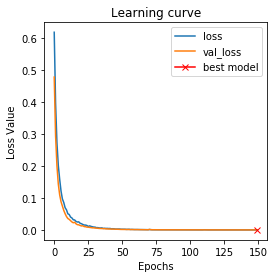

the minimum var_loss is 2.2554316354709652e-05
the Best epoch nr is 149
the maximum var_accuracy is 1.0
the maximum train_accuracy is 1.0
the Best epoch nr is 3


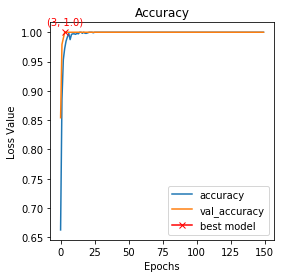

In [15]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(clf_hist.history["val_loss"]),
     np.min(clf_hist.history["val_loss"]),
     marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
plt.show()
print('the minimum var_loss is', np.min(clf_hist.history["val_loss"]))
print('the Best epoch nr is', np.argmin(clf_hist.history["val_loss"]))

#Accuracy
plt.figure(figsize=(4, 4))
plt.title("Accuracy")
plt.plot(clf_hist.history["binary_accuracy"], label="accuracy")
plt.plot(clf_hist.history["val_binary_accuracy"], label="val_accuracy")
xmax = np.argmax(clf_hist.history["val_binary_accuracy"])
ymax = np.max(clf_hist.history["val_binary_accuracy"])
plt.plot( xmax, ymax, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmax) + ', '+ str(round(ymax,2)) + ')', xy = (xmax, ymax + 0.01),
             horizontalalignment = "center", verticalalignment = "bottom", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
print('the maximum var_accuracy is', np.max(clf_hist.history["val_binary_accuracy"]))
print('the maximum train_accuracy is', np.max(clf_hist.history["binary_accuracy"]))
print('the Best epoch nr is', xmax)

In [16]:
# Skin
train_data_dir = '/DL_course_data/Lab2/Skin/train/'
validation_data_dir = '/DL_course_data/Lab2/Skin/validation/'
# number of data for each class
Len_C1_Train = get_length(train_data_dir,'Mel')
Len_C2_Train = get_length(train_data_dir,'Nevi')
Len_C1_Val = get_length(validation_data_dir,'Mel')
Len_C2_Val = get_length(validation_data_dir,'Nevi')
# loading the pre-trained model
# include top: false means that the dense layers at the top of the network will not be used.
model = applications.VGG16(input_shape=[img_width,img_height]+[3],include_top=False, weights='imagenet')
model.trainable = False
# Feature extraction from pretrained VGG (training data)
datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = datagen.flow_from_directory(train_data_dir,
                                              target_size=(img_width, img_height),
                                              batch_size=batchsize,
                                              class_mode='binary',#None'',
                                              shuffle=False)  
# Extracting the features from the loaded images
features_train = model.predict_generator(train_generator,
                                         (Len_C1_Train+Len_C2_Train) // batchsize, max_queue_size=1)
# Feature extraction from pretrained VGG (validation data)
val_generator = datagen.flow_from_directory(validation_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=batchsize,
                                            class_mode='binary',#None'',
                                            shuffle=False)  
# Extracting the features from the loaded images
features_val = model.predict_generator(val_generator,
                                       (Len_C1_Val+Len_C2_Val) // batchsize, max_queue_size=1)         


Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [17]:
features_train.shape

(1000, 7, 7, 512)

In [18]:
# training a small MLP with extracted features from the pre-trained model
# In fact this MLP will be used instead of the dense layers of the VGG model
# and only this MLP will be trained on the dataset.
train_data = features_train
train_labels = np.array([0] * int(Len_C1_Train) + [1] * int(Len_C2_Train))
validation_data = features_val
validation_labels = np.array([0] * int(Len_C1_Val) + [1] * int(Len_C2_Val))
input_size =(Img_w,Img_h,Nr_c)
inputs_layer = Input(shape=input_size, name='input_layer')
layer0 = Flatten()(inputs_layer)
layer1 = Dense(128, activation='relu')(layer0)
layer2 = Dropout(0.5)(layer1)
prediction = Dense(1, activation='sigmoid')(layer2)
MPL =Model(inputs=inputs_layer,outputs=prediction)
MPL.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 7, 7, 512)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 3,211,521
Trainable params: 3,211,521
Non-trainable params: 0
_________________________________________________________________


In [19]:
MPL.compile(loss='binary_crossentropy', optimizer = Adam(lr = LR), metrics=['binary_accuracy'])
clf_hist = MPL.fit(train_data, train_labels, epochs = epochs, batch_size = batchsize, validation_data=(validation_data, validation_labels))

Train on 1000 samples, validate on 200 samples
Epoch 1/150
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.6642 - binary_accuracy: 0.6070 - val_loss: 0.5250 - val_binary_accuracy: 0.8500
Epoch 2/150
1000/1000 [==============================] - 1s 802us/sample - loss: 0.5211 - binary_accuracy: 0.7660 - val_loss: 0.4601 - val_binary_accuracy: 0.8650
Epoch 3/150
1000/1000 [==============================] - 1s 795us/sample - loss: 0.4736 - binary_accuracy: 0.7950 - val_loss: 0.4208 - val_binary_accuracy: 0.8400
Epoch 4/150
1000/1000 [==============================] - 1s 802us/sample - loss: 0.4503 - binary_accuracy: 0.8000 - val_loss: 0.4061 - val_binary_accuracy: 0.8650
Epoch 5/150
1000/1000 [==============================] - 1s 802us/sample - loss: 0.4266 - binary_accuracy: 0.8000 - val_loss: 0.3937 - val_binary_accuracy: 0.8600
Epoch 6/150
1000/1000 [==============================] - 1s 800us/sample - loss: 0.4161 - binary_accuracy: 0.8150 - val_loss: 0.3787 - val_b

Epoch 51/150
1000/1000 [==============================] - 1s 805us/sample - loss: 0.2087 - binary_accuracy: 0.9210 - val_loss: 0.3105 - val_binary_accuracy: 0.8700
Epoch 52/150
1000/1000 [==============================] - 1s 814us/sample - loss: 0.2016 - binary_accuracy: 0.9310 - val_loss: 0.3114 - val_binary_accuracy: 0.8750
Epoch 53/150
1000/1000 [==============================] - 1s 817us/sample - loss: 0.2043 - binary_accuracy: 0.9270 - val_loss: 0.3174 - val_binary_accuracy: 0.8650
Epoch 54/150
1000/1000 [==============================] - 1s 803us/sample - loss: 0.2006 - binary_accuracy: 0.9250 - val_loss: 0.3179 - val_binary_accuracy: 0.8650
Epoch 55/150
1000/1000 [==============================] - 1s 803us/sample - loss: 0.2040 - binary_accuracy: 0.9270 - val_loss: 0.3124 - val_binary_accuracy: 0.8700
Epoch 56/150
1000/1000 [==============================] - 1s 809us/sample - loss: 0.1979 - binary_accuracy: 0.9200 - val_loss: 0.3103 - val_binary_accuracy: 0.8700
Epoch 57/150
100

Epoch 101/150
1000/1000 [==============================] - 1s 793us/sample - loss: 0.1117 - binary_accuracy: 0.9730 - val_loss: 0.3104 - val_binary_accuracy: 0.8700
Epoch 102/150
1000/1000 [==============================] - 1s 811us/sample - loss: 0.1112 - binary_accuracy: 0.9750 - val_loss: 0.3089 - val_binary_accuracy: 0.8750
Epoch 103/150
1000/1000 [==============================] - 1s 812us/sample - loss: 0.1104 - binary_accuracy: 0.9690 - val_loss: 0.3086 - val_binary_accuracy: 0.8700
Epoch 104/150
1000/1000 [==============================] - 1s 812us/sample - loss: 0.1120 - binary_accuracy: 0.9720 - val_loss: 0.3222 - val_binary_accuracy: 0.8650
Epoch 105/150
1000/1000 [==============================] - 1s 808us/sample - loss: 0.1130 - binary_accuracy: 0.9620 - val_loss: 0.3126 - val_binary_accuracy: 0.8700
Epoch 106/150
1000/1000 [==============================] - 1s 800us/sample - loss: 0.1064 - binary_accuracy: 0.9750 - val_loss: 0.3162 - val_binary_accuracy: 0.8750
Epoch 107/

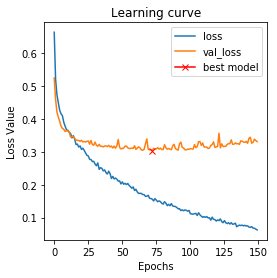

the minimum var_loss is 0.3042495283484459
the Best epoch nr is 72
the maximum var_accuracy is 0.885
the maximum train_accuracy is 0.992
the Best epoch nr is 36


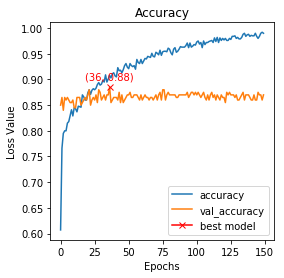

In [20]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(clf_hist.history["val_loss"]),
     np.min(clf_hist.history["val_loss"]),
     marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
plt.show()
print('the minimum var_loss is', np.min(clf_hist.history["val_loss"]))
print('the Best epoch nr is', np.argmin(clf_hist.history["val_loss"]))

#Accuracy
plt.figure(figsize=(4, 4))
plt.title("Accuracy")
plt.plot(clf_hist.history["binary_accuracy"], label="accuracy")
plt.plot(clf_hist.history["val_binary_accuracy"], label="val_accuracy")
xmax = np.argmax(clf_hist.history["val_binary_accuracy"])
ymax = np.max(clf_hist.history["val_binary_accuracy"])
plt.plot( xmax, ymax, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmax) + ', '+ str(round(ymax,2)) + ')', xy = (xmax, ymax + 0.01),
             horizontalalignment = "center", verticalalignment = "bottom", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
print('the maximum var_accuracy is', np.max(clf_hist.history["val_binary_accuracy"]))
print('the maximum train_accuracy is', np.max(clf_hist.history["binary_accuracy"]))
print('the Best epoch nr is', xmax)